In [9]:
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask
import fiona
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import time

### Get dataframe for HDI

In [10]:
hdi_path = 'data/shdi/SHDI Complete 4.0 (1).csv'
df = pd.read_csv(hdi_path, usecols=['iso_code', 'year', 'level', 'GDLCODE', 'shdi'], low_memory=False)
# get HDI for Nigeria at subnational level for year 2018
df = df.loc[
        (df['iso_code'] == 'NGA') & 
        (df['year'] == 2018) & 
        (df['level'] == 'Subnat')]
df.drop(columns=['iso_code', 'year', 'level'], inplace=True)
df['shdi'] = df['shdi'].astype(float)
df.set_index('GDLCODE', inplace=True)
df_hdi = df

### Get level 1 admin units (federal states) shapefile

In [11]:
shapefile_path = 'data/shapefiles/GDL Shapefiles V4.shp'
shapes_NGA = {}

with fiona.open(shapefile_path) as shapefile:
    for feature in shapefile:
        if feature['properties']['country'] == 'Nigeria':
            shapes_NGA[feature['properties']['GDLcode']] = feature['geometry']

### Set threshold and compute balanced accuracy for each federal state
* https://rasterio.readthedocs.io/en/latest/topics/masking-by-shapefile.html
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

In [12]:
threshold = 3

In [3]:
bal_accuracy = {}
f1 = {}
precision = {}
recall = {}

start_time = time.time()
for region, shape in shapes_NGA.items():
    
    # get truth
    with rasterio.open('data/grid3/NGA - population - v1.2 - mastergrid.tif') as dataset:
        truth = rasterio.mask.mask(dataset, [shape], all_touched=False, nodata=255)[0]
        truth = truth.flatten()
        truth = truth[truth != 255]
    
    # get prediction
    with rasterio.open('data/metrics/pipeline-counts.tif') as dataset:
        counts = rasterio.mask.mask(dataset, [shape], all_touched=False, nodata=255)[0]
        counts = counts.flatten()
        counts = counts[counts != 255]
        prediction = np.zeros(counts.size, dtype=np.uint8)
        prediction[counts > threshold] = 1
        
    bal_accuracy[region] = balanced_accuracy_score(truth, prediction)
    f1[region] = f1_score(truth, prediction)
    precision[region] = precision_score(truth, prediction)
    recall[region] = recall_score(truth, prediction)
    
print(f'taken: {time.time()-start_time} seconds')

NameError: name 'shapes_NGA' is not defined

### Make dataframe for balanced accuracy

In [103]:
df_score = pd.DataFrame(index=balanced_accuracy.keys(), data=[bal_accuracy.values(), f1.values(), precision.valuees(), recall.values()], columns=['balanced_accuracy', 'f1_score', 'precision', 'recall'])
df_score.index.rename('GDLCODE', inplace=True)

### Join HDI and balanced accuracy dataframes on region codes

In [104]:
df = df_hdi.join(df_score)
df.head()

,shdi,balanced_accuracy
GDLCODE,,
NGAr101,0.604,0.590610
NGAr102,0.656,0.608677
NGAr103,0.426,0.550705
NGAr104,0.622,0.684273
NGAr105,0.598,0.528291


### Plot HDI vs. balanced accuracy

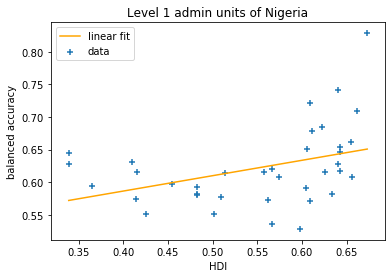

In [105]:
import matplotlib.pyplot as plt

plt.plot(np.unique(df.shdi), np.poly1d(np.polyfit(df.shdi, df.balanced_accuracy, 1))(np.unique(df.shdi)), c='orange', label='linear fit')
plt.scatter(df.shdi, df.balanced_accuracy, marker='+', label='data')
plt.ylabel('balanced accuracy')
plt.xlabel('HDI')
plt.title('Level 1 admin units of Nigeria')
plt.legend()
plt.show()